In [1]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action
from matplotlib import font_manager
import json

matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())
item = random.choice(data)
print(item)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']
video: stu6_31.mp4
class: pull_up
count: 20
reps: [30, 65, 65, 95, 95, 123, 123, 158, 159, 186, 186, 217, 218, 252, 252, 283, 283, 314, 315, 343, 343, 374, 374, 406, 406, 436, 436, 473, 474, 503, 503, 536, 536, 568, 568, 600, 600, 636, 636, 672]
fps: 30.0


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


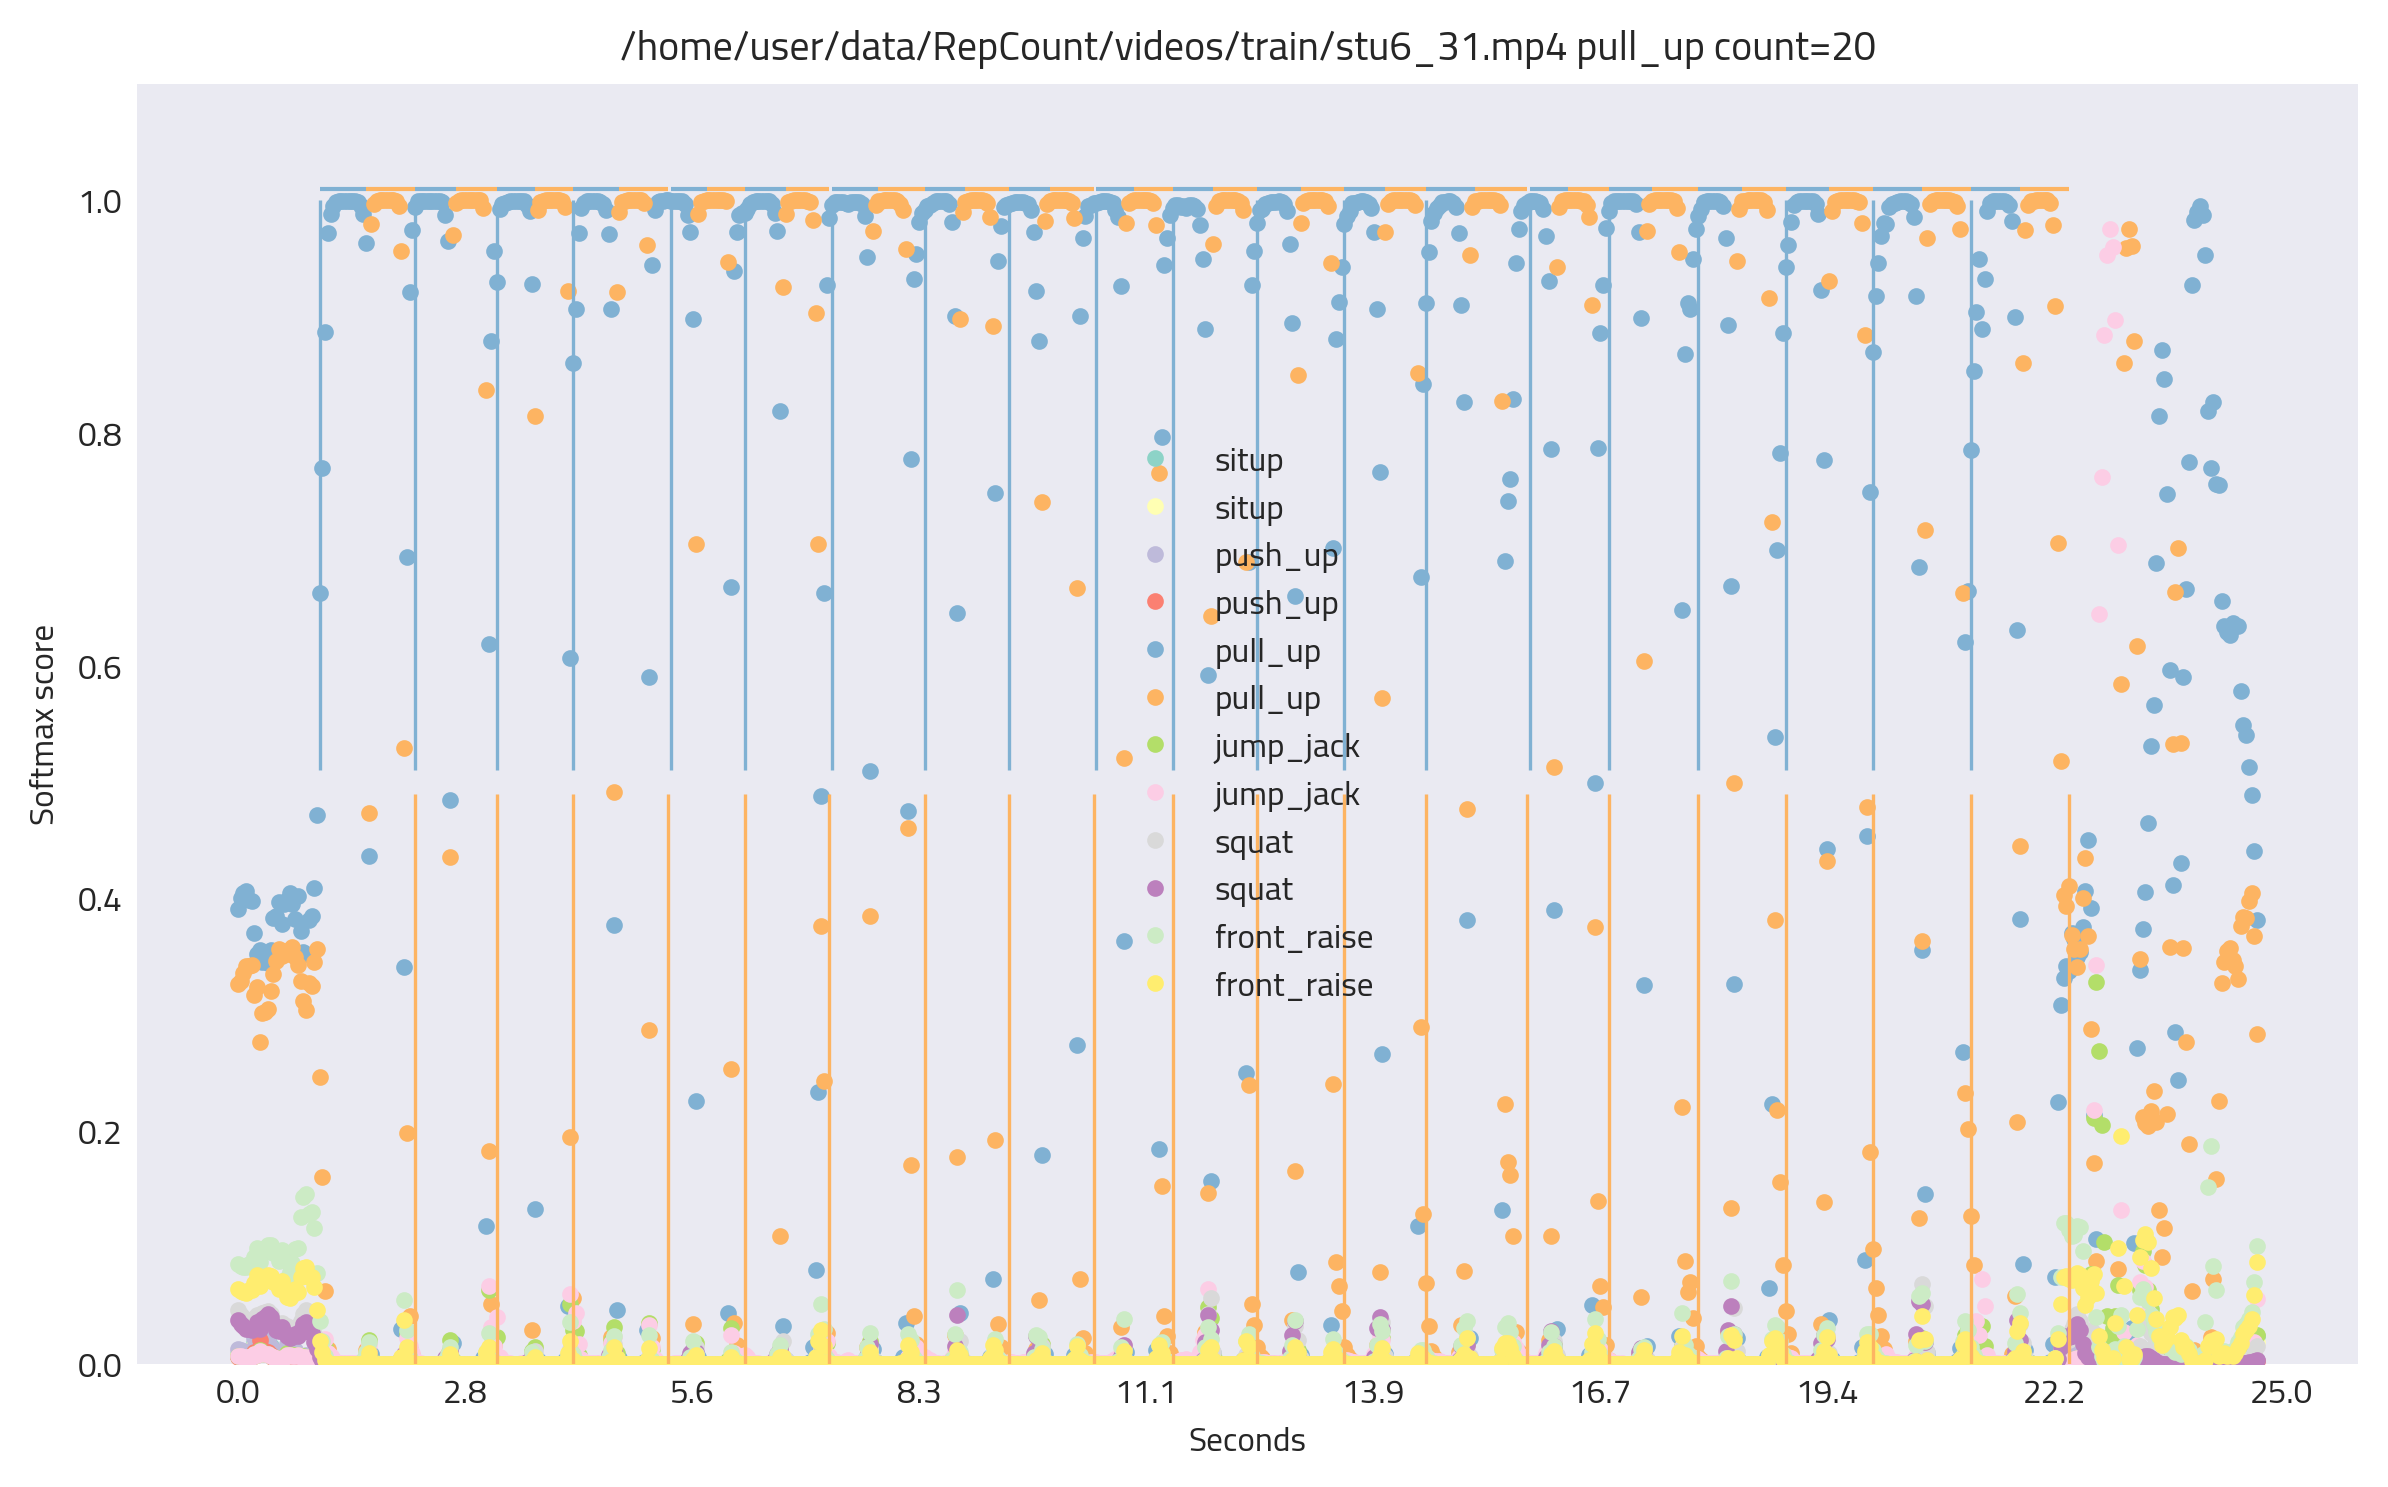

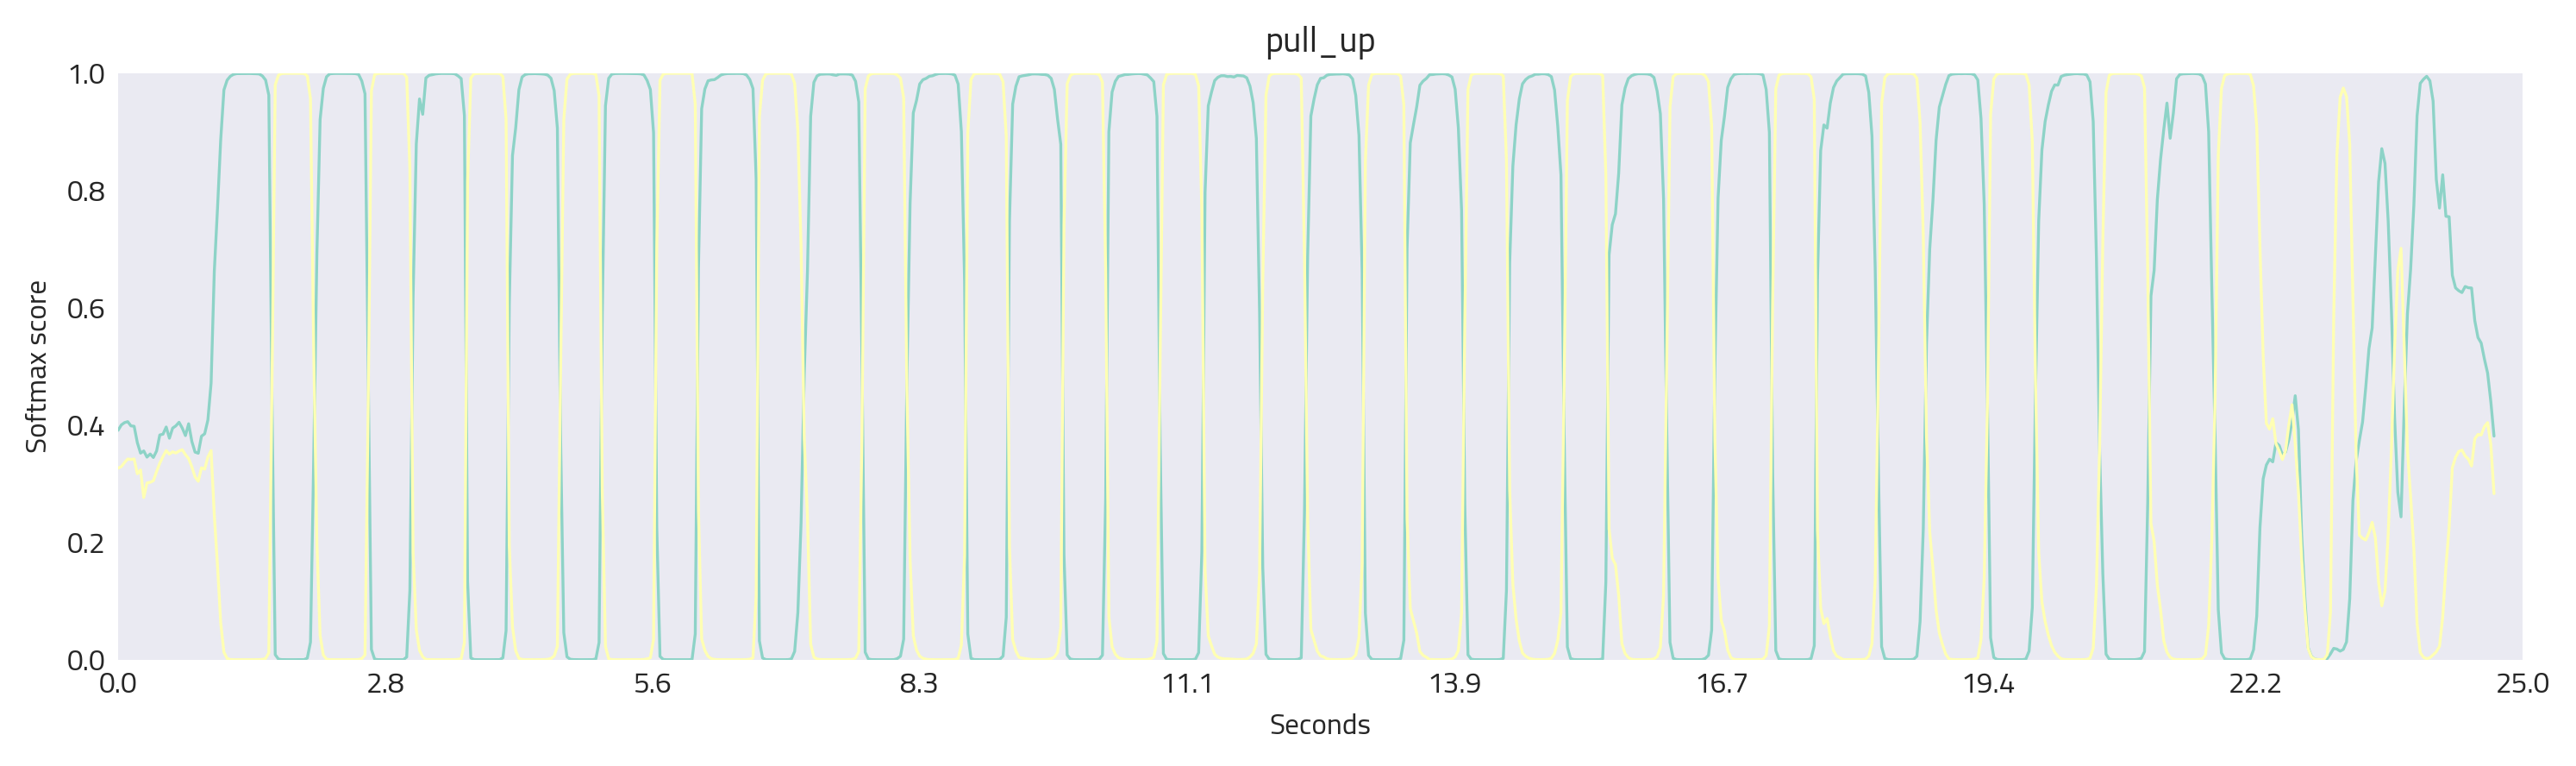

In [4]:
js = json.load(open(osj(json_dir, template.format(item.video_name))))

plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a float

In [5]:
from hmmlearn import hmm
from collections import Counter
from workoutdetector.datasets import FeatureDataset
from torch.utils.data import DataLoader

In [7]:
feat_ds = FeatureDataset(json_dir, anno_path, 'train', 'squat', window=1, stride=1)
print(feat_ds.x.shape)
transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x, feat_ds.y)
print(transmat, pi, means, cov)

(87573, 1, 12)
[0.21200598 0.         0.         0.         0.         0.
 0.         0.         0.         0.39149053 0.39650349] [[0.97538379 0.         0.         0.         0.         0.
  0.         0.         0.         0.02461621 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.      

In [8]:
model = hmm.GaussianHMM(n_components=3, n_iter=300)
model.fit(feat_ds.x.squeeze(1))

GaussianHMM(n_components=3, n_iter=300)

(1792, 12) 1792
1792
[1 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 2
 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1]
[0 0 0 0 0 1 2 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 1 1 2 1 2 1 2 1 0 2 0 2 1 2 1 2
 2 1 2 1 2 1 2 1 1 2 1 2 1 2 0 0]
count 44 name stu4_70.mp4 squat
acc 0.43861607142857145


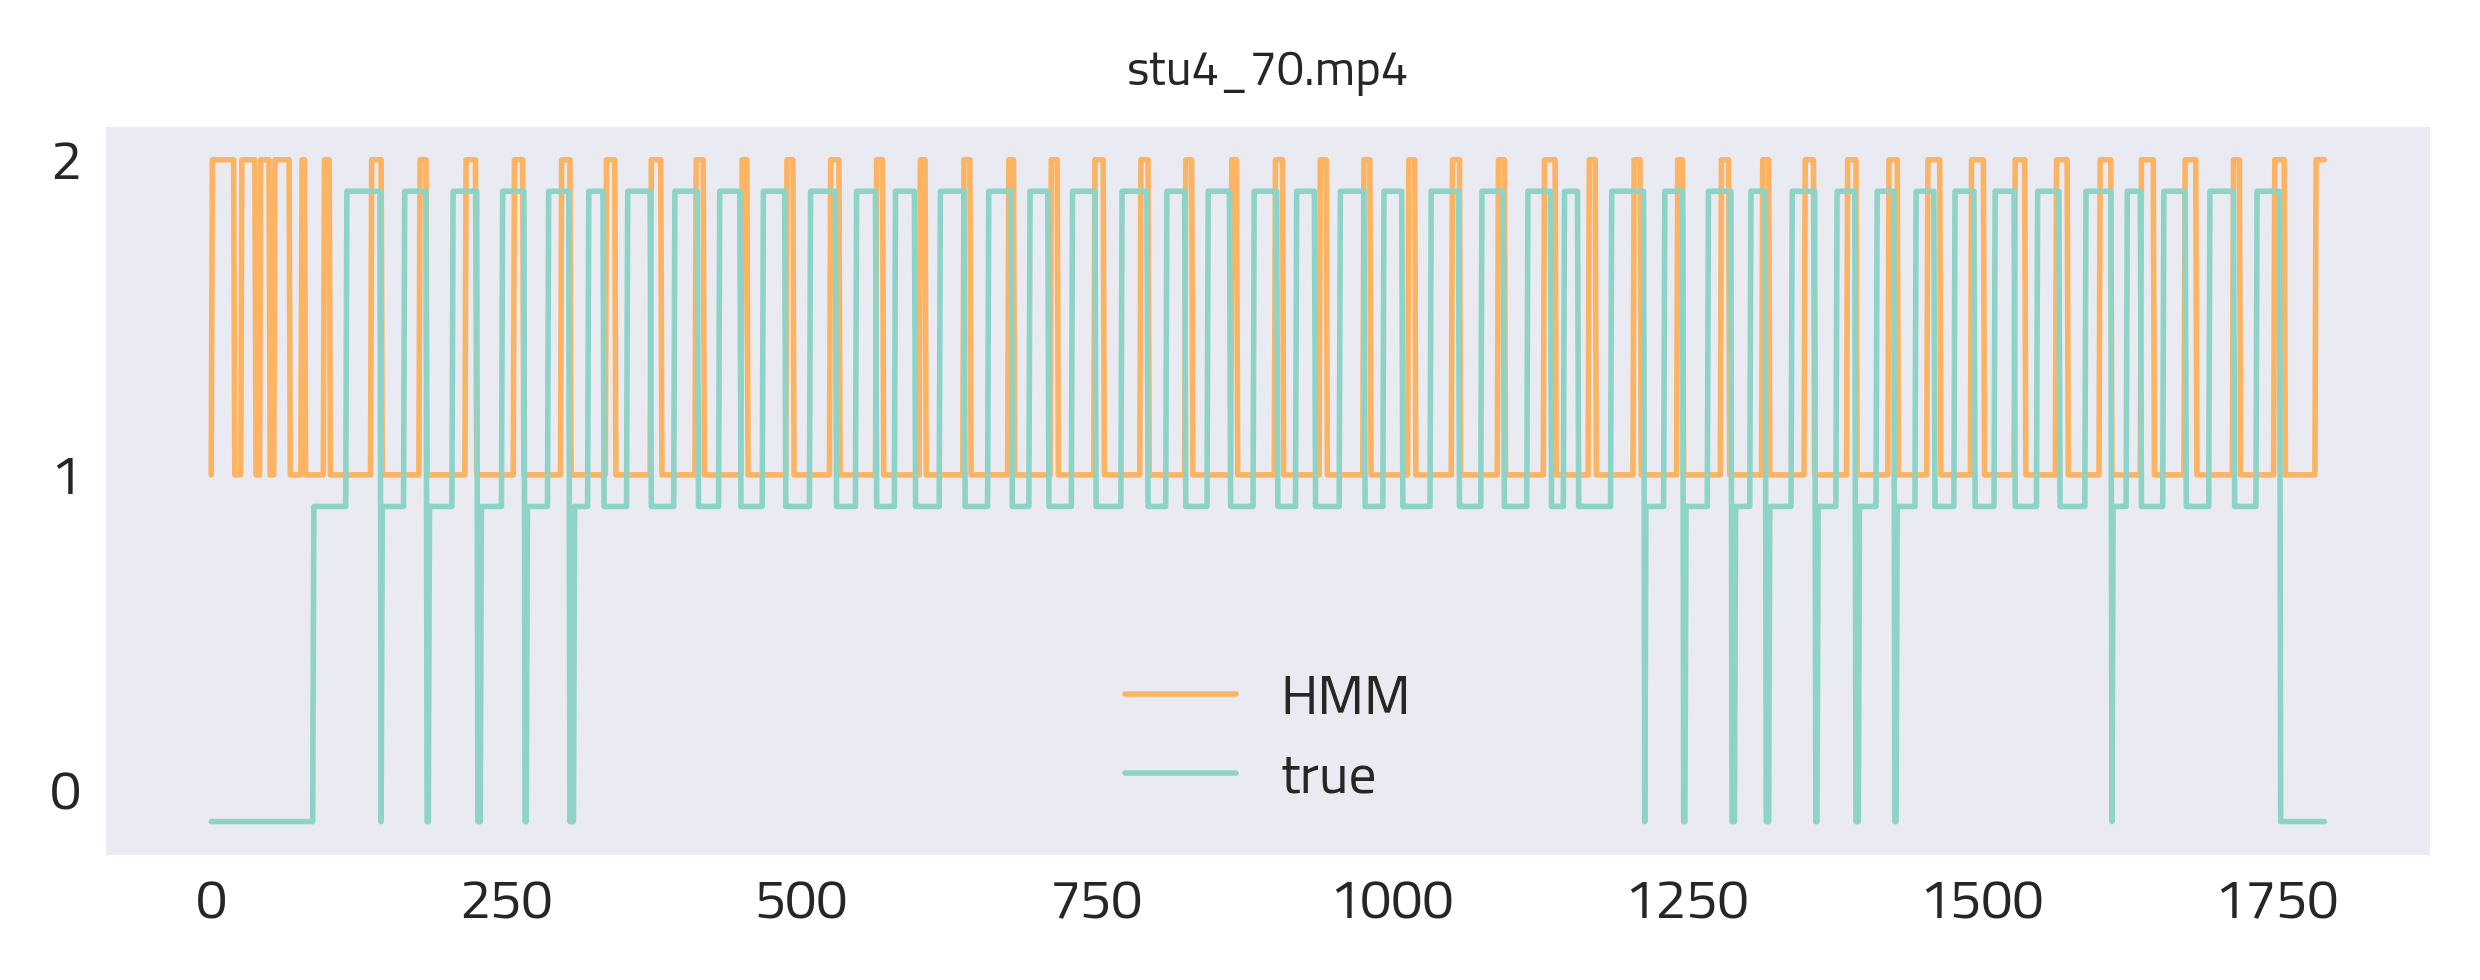

In [108]:
val_data = list(helper.get_rep_data(['val'], ['squat']).values())
item = random.choice(val_data)
val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
val_y = reps_to_label(item.reps, item.total_frames, item.class_)[0:0+len(val_x)]
val_y = np.array(val_y)
print(val_x.shape, len(val_y))

pred = model.predict(val_x)
print(len(pred))
print(pred[::20])
print(val_y[::20])
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)

acc = (pred == val_y).mean()
print('acc', acc)

fig= plt.figure(figsize=(5,2), dpi=500)
plt.tight_layout()
plt.plot(pred, 'C5', label='HMM')
plt.plot(val_y-0.1, 'C0', label='true')
plt.yticks(range(3))
plt.legend()
plt.title(f'{item.video_name}', fontsize=7)
plt.show()

### Eval

## MLP

In [30]:
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)

window = 10
model_mlp = MLP(12*window, 100, 13)

In [63]:
train_x, train_y = [], []
for item in data:
    x, y = [], []
    js = json.load(open(osj(json_dir, template.format(item.video_name))))
    for i,v in js['scores'].items():
        x.append(np.array(list(v.values())))
    y = reps_to_label(item.reps, item.total_frames, item.class_)
    x, y = torch.Tensor(x), torch.Tensor(y)
    n = len(x) - window + 1
    for i in range(n):
        train_x.append(x[i:i+window])
        train_y.append(y[7+i])

print(len(train_x), len(train_y))
print(train_x[0].shape, train_y[0])

loader = zip(train_x, train_y)
model_mlp.to('cuda')
train_x = torch.stack(train_x).to('cuda')
train_y = torch.stack(train_y).to('cuda')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)
    
train_loader = DataLoader(Dataset(train_x, train_y), batch_size=64, shuffle=True)
val_loader = DataLoader(Dataset(val_x, val_y), batch_size=64, shuffle=False)
next(iter(loader))[0].shape

640141 640141
torch.Size([10, 12]) tensor(11.)


torch.Size([64, 10, 12])

In [64]:
def train(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for _ in range(10):
        model.train()
        model.zero_grad()
        train_loss = 0
        for x, y in train_loader:
            output = model(x)
            loss = F.cross_entropy(output, y.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(loader)
        print('train loss', train_loss)

        model.eval()
        val_loss = 0
        val_acc = 0
        for x, y in val_loader:
            output = model(x)
            loss = F.cross_entropy(output, y.long())
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == y).sum().item()
        val_loss /= len(loader)
        val_acc /= len(train_x)
        print('val loss', val_loss)
        print('val acc', val_acc)

## LSTM

In [67]:
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        x, (h, c) = self.rnn(x, (h0, c0))
        o = self.layers(h[-1])
        return o

model_lstm = LSTM(12, 2, 128, 13).cuda()
model_lstm(torch.randn(64, 10, 12).cuda()).shape

torch.Size([64, 13])

In [ ]:
train(model_lstm, train_loader, val_loader)